In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

In [ ]:
!pip install timm

In [49]:
!unzip -qq /content/drive/MyDrive/CV_project/data/SKIN/region/H/aug_multi_H.zip -d /content/6classes

In [7]:
import os, random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets, transforms

import timm
import tqdm

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
!nvidia-smi

Tue May 28 05:59:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   41C    P8              12W /  72W |      4MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Load Data

In [76]:
batch_size = 64
img_size = 224
model_type = 'regionH-multi'

data_dir = '/content/6classes'

In [51]:
mean_ = (0.5589, 0.5298, 0.5114)
std_ = (0.2119, 0.2031, 0.2015)

In [52]:
from torchvision.transforms import (
    Compose,
    ToTensor,
    Normalize,
    RandomHorizontalFlip,
    RandomVerticalFlip
)

transforms = Compose(
        [
            ToTensor(),
            Normalize(mean_, std_),
            RandomHorizontalFlip(),
            RandomVerticalFlip()
        ]
    )

In [53]:
dataset = datasets.ImageFolder(data_dir, transforms)

In [54]:
# train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms)
# valid_dataset = datasets.ImageFolder(os.path.join(data_dir, 'valid'), transforms)
# test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms)

In [55]:
torch.manual_seed(42)

train_size = int(len(dataset)*0.8)
valid_size = len(dataset) - train_size

train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])
labels = dataset.classes
num_classes = len(labels)
labels

['A1_구진_플라크',
 'A2_비듬_각질_상피성잔고리',
 'A3_태선화_과다색소침착',
 'A4_농포_여드름',
 'A5_미란_궤양',
 'A6_결절_종괴']

In [56]:
print(len(train_dataset), len(valid_dataset))

67680 16920


In [57]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=4,
                                          pin_memory=True)

valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=4,
                                          pin_memory=True)

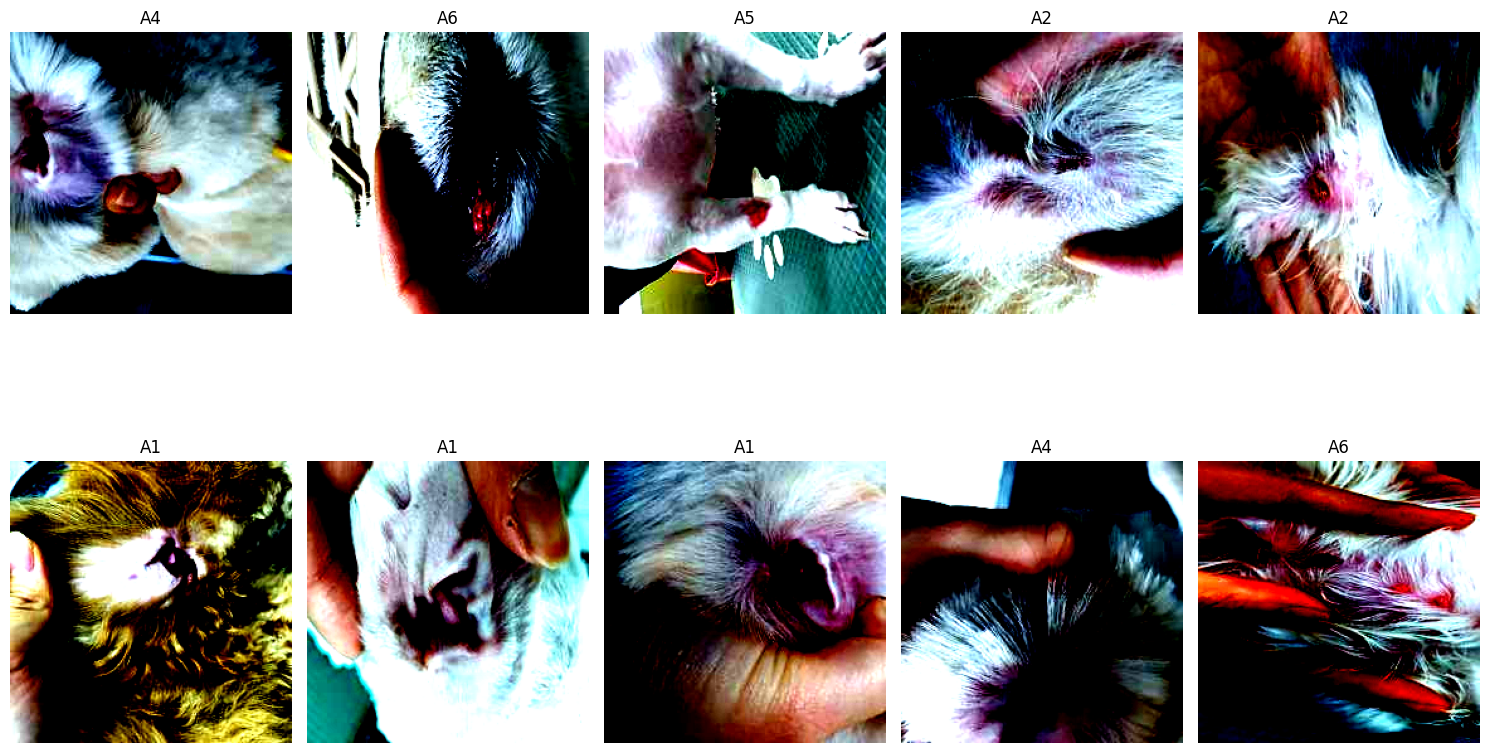

In [58]:
valid_10 = [valid_dataset[i] for i in random.sample(list(range(0, 14400)), 10)]

fig, ax = plt.subplots(2, 5, figsize=(15, 10), tight_layout=True)

for i in range(2):
    for j in range(5):
        img = valid_10[(i*5)+j][0]
        img = img.numpy().transpose((1, 2, 0))
        img = np.clip(img, 0, 1)
        ax[i][j].imshow(img)
        ax[i][j].set_title(labels[valid_10[(i*5)+j][1]][:2])
        ax[i][j].axis('off')

plt.show()

# Model Training

In [ ]:
# inception_v4 1536
# inception_resnet_v2 1536
# resnet50 2048
# resnetv2_50 2048
# efficientnet_b0 1280
# vit_base_patch16_224 768
# vit_base_patch8_224 768
# vit_base_resnet26d_224 768
# vit_base_resnet50d_224 768
# vit_small_resnet26d_224 768
# vit_small_resnet50d_s16_224 768

In [59]:
model_name = 'resnet50'
hidden_size = 768
pretrained = True
model = timm.create_model(model_name, pretrained=pretrained, num_classes=num_classes)

In [60]:
# for i, (name, param) in enumerate(model.named_parameters()):
#     print(i, name)

In [61]:
# if pretrained:
#     for i, (name, param) in enumerate(model.named_parameters()):
#         if 'head' in name:
#           print(i, name)
#           break

#         param.requires_grad = False

In [62]:
def calc_accuracy(X, Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [63]:
from IPython.display import clear_output

def loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch):

  figure, ax = plt.subplots(1, 2, figsize=(12, 5))

  ax[0].plot(train_loss_epoch)
  ax[0].plot(val_loss_epoch)
  ax[0].set_title('Loss-Epoch curve')
  ax[0].set_ylabel('Loss')
  ax[0].set_xlabel('Epoch')
  ax[0].legend(['train', 'val'], loc='upper right')

  ax[1].plot(train_acc_epoch)
  ax[1].plot(val_acc_epoch)
  ax[1].set_title('Model Accuracy')
  ax[1].set_ylabel('Accuracy')
  ax[1].set_xlabel('Epoch')
  ax[1].legend(['train', 'val'], loc='lower right')

  plt.show()

In [64]:
class Classifier(nn.Module):
    def __init__(self, model, num_classes=2):
        super().__init__()
        self.model = model
        self.classifier = nn.Linear(hidden_size, num_classes)
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.model(x)
        x = self.classifier(x)
        return x # self.sigmoid(x)

In [65]:
# classifier = Classifier(model, num_classes=num_classes).to(device)
classifier = model.to(device)

In [66]:
# optimizer = torch.optim.Adam(classifier.parameters(), lr=0.0001) # correct_bias=False # Adam
optimizer = torch.optim.AdamW(classifier.parameters(), lr=0.01, weight_decay=1e-5)
# optimizer = torch.optim.SGD(classifier.parameters(), lr=0.01, weight_decay=1e-5, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                         factor=0.5, patience=2)
loss_fn = nn.CrossEntropyLoss()

In [67]:
from collections import OrderedDict
import pickle

def save_checkpoint(epoch, labels, model, optimizer, lr_scheduler,
                    train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch,
                    model_path, filename):

    state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'lr_scheduler': lr_scheduler.state_dict(),
        'label': labels
    }
    torch.save(state, os.path.join(model_path, f'{filename}.pt'))

    config = {"train":{"acc":train_acc_epoch, "loss":train_loss_epoch},
          "valid":{"acc":val_acc_epoch, "loss":val_loss_epoch}}

    with open(os.path.join(model_path, f'{filename}.pickle'),'wb') as fw:
        pickle.dump(config, fw)

In [77]:
model_path = f'/content/drive/MyDrive/CV_project/skin_model/{model_type}'
os.makedirs(model_path, exist_ok=True)

In [69]:
def load_dict(model, optimizer, lr_scheduler, dict_file):

    pretrained = torch.load(dict_file)

    epoch = pretrained['epoch']
    state_dict = pretrained['state_dict']
    opt_dict = pretrained['optimizer']
    sch_dict = pretrained['lr_scheduler']
    labels = pretrained['label']

    model_dict = model.state_dict()
    model_dict.update(state_dict)
    model.load_state_dict(model_dict)

    optimizer.load_state_dict(opt_dict)
    lr_scheduler.load_state_dict(sch_dict)

    return epoch, labels, model, optimizer, lr_scheduler

In [70]:
import pickle
def load_records(pkl_file):
    with open(pkl_file, 'rb') as f:
        records = pickle.load(f)
    return records['train'], records['valid']

In [71]:
file_path = f'/kaggle/input/skin-disease-binary/binary-resnet50/binary'

pretrained = False

In [72]:
num_epochs = 10

best_val_acc, best_val_loss = 0.0, 100.0

train_loss_epoch, val_loss_epoch = [], []
train_acc_epoch, val_acc_epoch = [], []
lr_epoch = []
epoch_start = 0

classifier = classifier.to(device)

if pretrained:
    dict_file = os.path.join(file_path, f'{model_name}.pt')
    pkl_file = os.path.join(file_path, f'{model_name}.pickle')

    epoch_start, labels, model, optimizer, lr_scheduler = load_dict(classifier, optimizer, lr_scheduler, dict_file)
    train_epoch, valid_epoch = load_records(pkl_file)
    train_loss_epoch, train_acc_epoch = train_epoch['loss'], train_epoch['acc']
    val_loss_epoch, val_acc_epoch = valid_epoch['loss'], valid_epoch['acc']
    best_val_acc, best_val_loss = max(val_acc_epoch), min(val_loss_epoch)

In [80]:
print(epoch_start, best_val_acc, best_val_loss)

10 0.0 0.37595144853277024


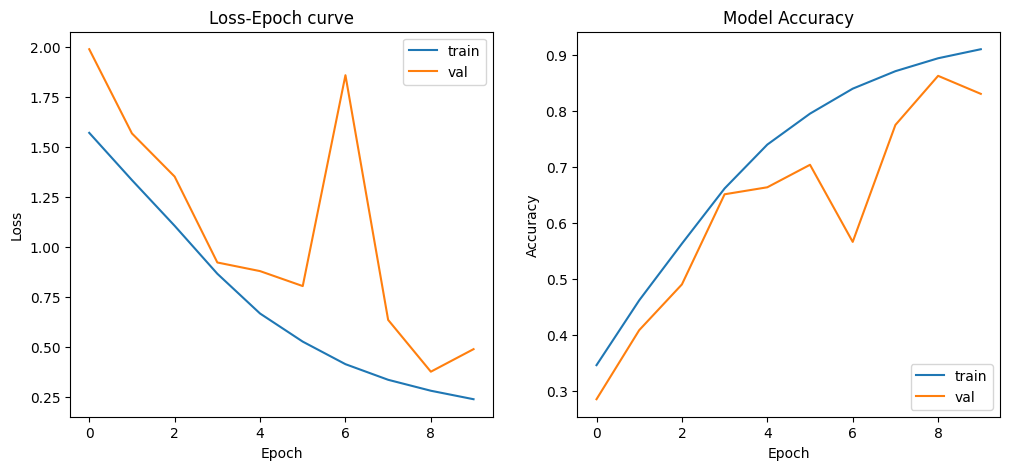

In [79]:
loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch)

In [78]:
epoch_start = 10
num_epochs = 10

epoch 19 train acc 0.972530718336484 validation acc 0.9356328616352202


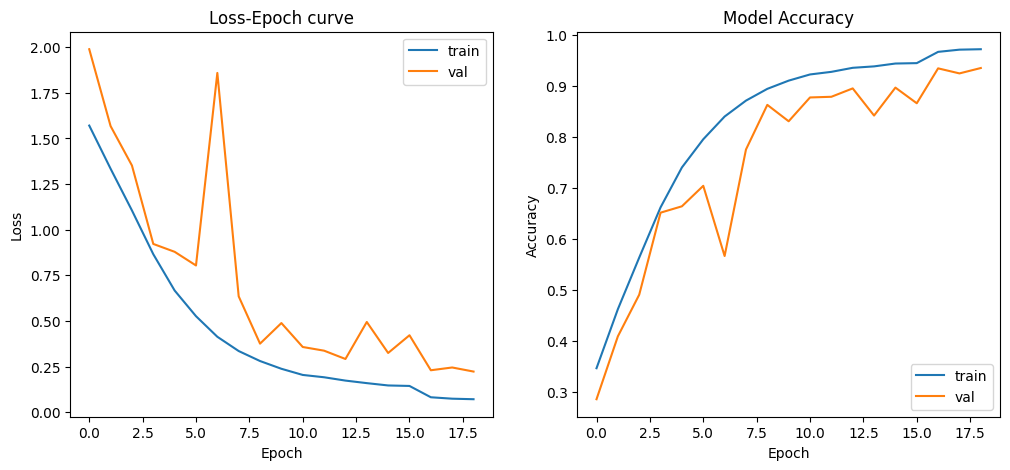

  0%|          | 0/1058 [00:00<?, ?it/s]

epoch 20 train acc 0.9753367202268431 loss 0.06599268091258034 lr 0.005


  0%|          | 0/265 [00:00<?, ?it/s]

epoch 20 valid acc 0.9323899371069183 loss 0.242061843055318


In [81]:
for e in range(epoch_start+1, num_epochs+epoch_start+1):
    train_acc, train_loss = 0.0, 0.0
    val_acc, val_loss = 0.0, 0.0
    classifier.train()
    for batch_id, batch in enumerate(tqdm.notebook.tqdm(train_loader)):
        optimizer.zero_grad()

        img = batch[0].to(device)
        label = batch[1].to(device) # .squeeze(1) .float()

        out = classifier(img).squeeze(1)
        loss = loss_fn(out, label)

        train_loss += loss.item()
        loss.backward()

        optimizer.step()

        train_acc += calc_accuracy(out, label)

    tot_train_acc = train_acc / (batch_id+1)
    mean_train_loss = train_loss / (batch_id+1)
    train_loss_epoch.append(mean_train_loss)
    train_acc_epoch.append(tot_train_acc)
    lr = optimizer.param_groups[0]['lr']
    lr_epoch.append(lr)
    print("epoch {} train acc {} loss {} lr {}".format(e, tot_train_acc, mean_train_loss, lr))

    classifier.eval()
    with torch.no_grad():
        for batch_id, batch in enumerate(tqdm.notebook.tqdm(valid_loader)):

            img = batch[0].to(device)
            label = batch[1].to(device) # .squeeze(1)

            out = classifier(img).squeeze(1)
            loss = loss_fn(out, label)
            val_loss += loss.item()
            val_acc += calc_accuracy(out, label)

    tot_acc = val_acc / (batch_id+1)
    mean_val_loss = val_loss / (batch_id+1)
    lr_scheduler.step(mean_val_loss)

    val_loss_epoch.append(mean_val_loss)
    val_acc_epoch.append(tot_acc)
    print("epoch {} valid acc {} loss {}".format(e, tot_acc, mean_val_loss))
    if best_val_loss > mean_val_loss:
      clear_output(wait=True)
      print("epoch {} train acc {} validation acc {}".format(e, tot_train_acc, tot_acc))
      loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch)
      best_val_loss = mean_val_loss
      save_checkpoint(e, labels, classifier, optimizer, lr_scheduler,
                      train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch,
                      model_path, model_name)

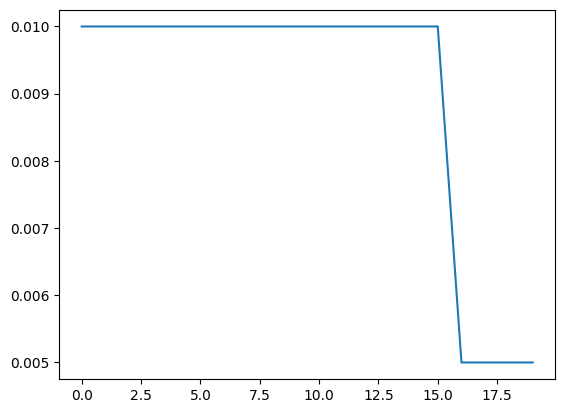

In [85]:
plt.plot(lr_epoch)
plt.show()

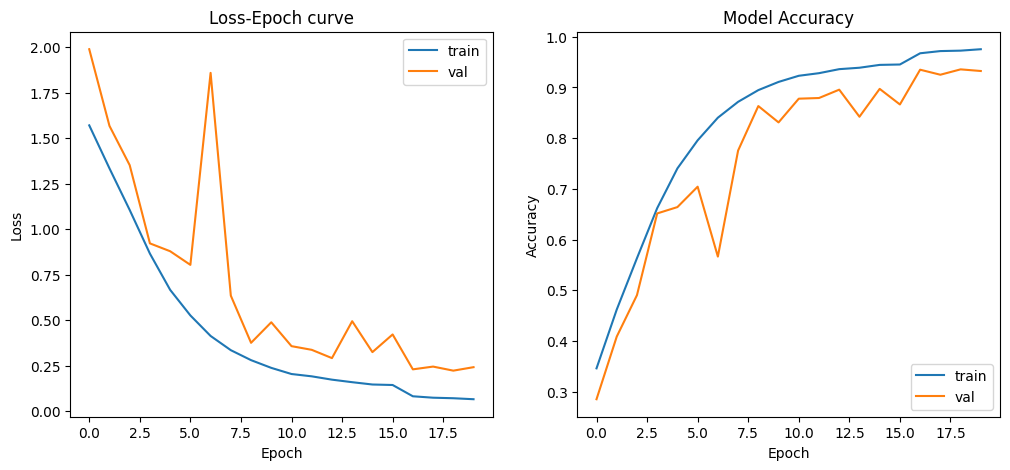

In [86]:
loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch)

In [ ]:
# data-all train 300897 valid 75225

# Resnet50                 1 epoch running
# Inceptionv4              1 epoch 50min
# Inception_resnet_v2      1 epoch 50min
# efficientnet_b0          1 epoch
# vit_small_resnet26d_224  1 epoch

# Inference

In [ ]:
def inference(img_path):

    img = Image.open(img_path)
    img = img.resize((224, 224))
    img = img.ToTensor()

    outputs = classifier(img)
    result = outputs.logits.softmax(1)
    result_dict = {}

    for i, value in enumerate(result[0].tolist()):
        result_dict[id2label[str(i)]] = value

    result = sorted(result_dict.items(), key=lambda x:x[1], reverse=True)

    return result

In [ ]:
# file_path = '/kaggle/input/cv-skin-disease/disease/IMG_C_A2_201354.jpg'
# result = inference(file_path)
# print(f'{result[0][0]}일 확률이 {int(result[0][1]*100)}%, {result[1][0]}일 확률이 {int(result[1][1]*100)}% 입니다.')

In [ ]:
# img = Image.open('/kaggle/input/skin-cat/test_cat_resized/A2_비듬_각질_상피성잔고리/IMG_C_A2_201688.jpg')
# encoding = feature_extractor(images=img, return_tensors='pt')

In [ ]:
# !pip install onnxruntime

In [ ]:
# import onnxruntime
# import time

# ort_session = onnxruntime.InferenceSession(filepath)
# input_name = ort_session.get_inputs()[0].name
# ort_inputs = {input_name: encoding['pixel_values'].numpy()}

# s = time.time()
# ort_outs = ort_session.run(None, ort_inputs)
# e = time.time()

# print(f'inference takes {e-s} sec')

In [ ]:
# from scipy.special import softmax

In [ ]:
# softmax(ort_outs)

In [ ]:
# encoding['pixel_values'].size()

In [ ]:
# ort_inputs

In [ ]:
# dataset.class_to_idx

In [ ]:
# import pickle

# with open('/kaggle/working/classes.pkl', 'wb') as f:
#     pickle.dump(id2label, f)